In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from pathlib import Path

In [3]:
import sys

sys.path.append('../../../src')

In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering,\
box_clustering, adaptive_box2, optimal_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths,\
confusion_matrix



In [5]:
np.random.seed(seed = 0)

In [6]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3

#axes_font = {'labelsize':l1}
#mpl.rc('font', **font)
#xticks = {'labelsize':l2}# 'ytick.labelsize':20}
#yticks = {'labelsize':l2}# 'ytick.labelsize':20}
#legend = {'fontsize':l3}
# tex = {'usetex':True}
#mpl.rc('axes', **axes_font)
#mpl.rc('xtick', **xticks)
#mpl.rc('ytick', **yticks)
#mpl.rc('font', **fonts)
#mpl.rc('legend', **legend

In [7]:
pd.set_option("display.max_columns", None)

### Directory to save figures

In [8]:
save = True
path_figs = './figs/200K/'
Path(path_figs).mkdir(exist_ok = True, parents = True)

### Generate Experiment

In [9]:
%%time

N,D = 2*10**5, 2
x = int((N)**(1/4))
clusters = x**2
print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
centers = [[0.25,0.25],[0.5,0.5],[0.75,0.75],[0.75,0.25], [0.25,0.75]]
r_small = [0.122]*5
r_big = [0.2,0.2,0.2, 0.2,0.2]
kw_cluster =  {'f_class_name':'circle_class3', 'centers': centers, 'r_small': r_small, 'r_big':r_big}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

std = 2
stats = np.array([[1, std], [0, std], [0, std], [0, std],[0, std],
                  [0, std],[1, std],[1, std],[2, std],[3, std],[4, std],[5, std]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

Number of Clusters:441, Number of Points:200000
CPU times: user 205 ms, sys: 66.4 ms, total: 272 ms
Wall time: 404 ms


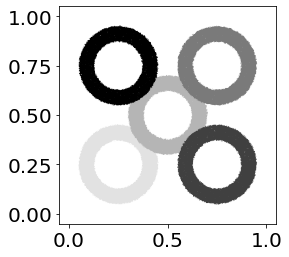

In [10]:
fig, ax = plt.subplots()

ax.scatter(data['x0'].values, data['x1'].values, c=data['C'].values, cmap = 'Greys', s=0.1)

ax.set_aspect('equal', adjustable='box')
fig.savefig(path_figs+'data.jpeg',bbox_inches='tight', pad_inches = 0)

plt.show()

 ### Estimate ITE with Gradient Boosting Trees

In [11]:
%%time
f1_kwargs = {'n_estimators':400, 'max_depth':18}
f2_kwargs = {'n_estimators':400, 'max_depth':18}

data, models = predict_cf(data.copy(), col_select = ['x0', 'x1'], f1 = GDBR,
                          f2 = GDBR, cf_name = 'Ycf-GDBR', f1_kwargs=f1_kwargs, 
                          f2_kwargs=f2_kwargs, ite_name ='ITE-GDBR')

CPU times: user 6min 19s, sys: 202 ms, total: 6min 20s
Wall time: 6min 22s


### Apply box clustering to use for the adaptive algorithm

In [12]:
col_select = ['x0', 'x1']
data,_ = box_clustering(data.copy(), clusters = clusters, col_select = col_select )

### Calculate ATT per box cluster for optimal clustering

In [13]:
ite_name = 'ITE-GDBR'
box2 = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', ITE_name = ite_name,
            hom_name = 'Box-Hom', att = False)

### Optimal 1d means recover

In [14]:
name2 = 'Box-ATT'
name = 'Opt-Clust'
val = 6
box2, means = optimal_clustering(box2, max_clusters = 7, col_select = name2, 
                      cluster_name = name, N=N, val = val)

Did not pick 6, it picked: 5


In [15]:
data.head(3)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster
0,0.548814,0.715189,0,0,2.867530,0.508965,-2.358565,0,1.685840,-1.181690,326
1,0.602763,0.544883,0,1,2.046206,-1.220069,3.266275,0,1.095254,0.950951,243
2,0.423655,0.645894,2,0,-3.383970,-1.180936,2.203034,0,2.571271,5.955240,281


### Adaptive Box

In [16]:
%%time
adaptive_ite_name = 'ITE-ADAPTIVE'
ite_old_name = 'ITE-GDBR'
data = adaptive_box2(data, clusters = clusters, ite_old_name = ite_old_name,
                    ite_name = adaptive_ite_name, col_select = col_select)

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'data_groups2' of function 'adapt_numba'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../src/clustering_algos.py", line 478:
@jit(nopython = True)
def adapt_numba(data_groups2, new_ites, values, pivot_array,
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


CPU times: user 5min 1s, sys: 577 ms, total: 5min 1s
Wall time: 5min 10s


In [17]:
data.head(3)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,ITE-ADAPTIVE
0,0.548814,0.715189,0,0,2.867530,0.508965,-2.358565,0,1.685840,-1.181690,326,1.645554
1,0.602763,0.544883,0,1,2.046206,-1.220069,3.266275,0,1.095254,0.950951,243,0.921971
2,0.423655,0.645894,2,0,-3.383970,-1.180936,2.203034,0,2.571271,5.955240,281,3.185426


In [18]:
clusts = len(means)
means2 = means.reshape(val,1)

data, km = kmeans_clustering(data, clusters = clusts, cluster_name = 'ITE-ADAPTIVE-3CLUST',
                           col_select = [adaptive_ite_name], assign_means = True, means = means2 )

In [19]:
print(means2)
print(km.cluster_centers_)

[[0.06880586]
 [1.01598655]
 [1.91594703]
 [2.88872531]
 [3.82840568]
 [4.88785604]]
[[0.06880586]
 [1.01598655]
 [1.91594703]
 [2.88872531]
 [3.82840568]
 [4.88785604]]


### Adaptive ITES values scatter plot

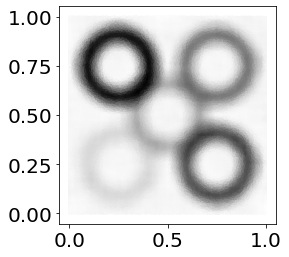

In [20]:
path3 = path_figs+'reconstruction/'
Path(path3).mkdir(exist_ok = True, parents = True)

fig, ax = plt.subplots()

sc = ax.scatter(data['x0'].values, data['x1'].values, c=data[adaptive_ite_name], cmap = 'Greys', s = 1)
if save:
    ax.set_aspect('equal', adjustable='box')
    fig.savefig(path3+'{}.jpeg'.format('ites'), bbox_inches='tight',pad_inches = 0)

###  Clustering of Adaptive ites

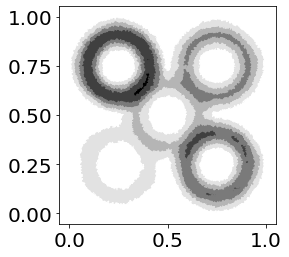

In [21]:
fig, ax = plt.subplots()

sc = ax.scatter(data['x0'].values, data['x1'].values, c=data['ITE-ADAPTIVE-3CLUST'], cmap = 'Greys', s = 1)

if save:
    ax.set_aspect('equal', adjustable='box')
    fig.savefig(path3+'{}.jpeg'.format('ITE-ADAPTIVE-3CLUST'), bbox_inches='tight',pad_inches = 0)

### Histogram of Adaptive Ites

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


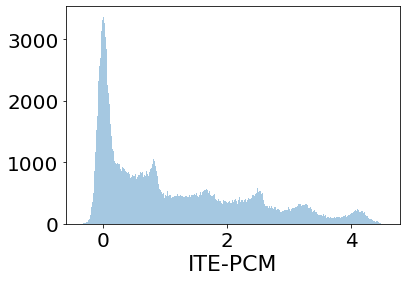

In [22]:
path2 = path_figs+'histograms/'
Path(path2).mkdir(exist_ok = True)

fig, ax = plt.subplots()

ax = sns.distplot(data[adaptive_ite_name],  bins=400, kde = False,ax = ax)
ax.set_xlabel('ITE-PCM')

#ax.set_xlim(-0.5,2.5)
if save:
    fig.savefig(path2+'adaptivehist.pdf', bbox_inches='tight',pad_inches = 0)


In [23]:
def MAE_pd(group, name1,name2,column_name):
    
    group[column_name] = np.abs(group[name1].values-group[name2].mean())
    return group
    
    

In [24]:
ite_column = 'ITE-GDBR'
clust2 = 'ITE-ADAPTIVE-3CLUST'
data = data.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-GDBR'))

In [25]:
ite_column = 'ITE'

data = data.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-True-ITE'))

In [26]:
errors = data.describe().loc[['mean', 'std'], [col for col in data.columns if 'err' in col]].T

In [27]:
errors.sort_values(by = 'mean')

,mean,std
ITE-ADAPTIVE-3CLUST-err-True-ITE,0.456375,0.630587
ITE-ADAPTIVE-3CLUST-err-GDBR,0.467131,0.623827


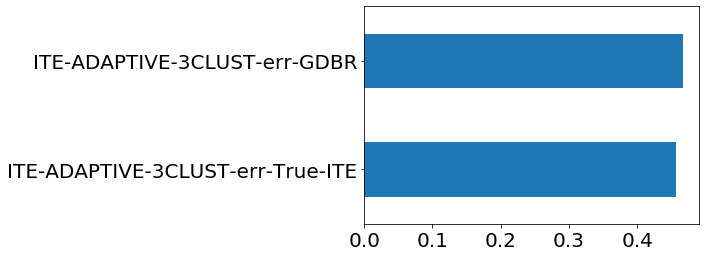

In [28]:
ax = errors['mean'].sort_values().plot.barh()
plt.show()

In [29]:
from IPython.display import display

path4 = path_figs+'matrices/'
Path(path4).mkdir(exist_ok = True)

mat = confusion_matrix(data, 'C', 'ITE-ADAPTIVE-3CLUST', 6, save = save, save_dir = path4)
print(name)
display(mat)

Opt-Clust


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.669475,0.231314,0.090094,0.009117,0.000000,0.000000
C1 True,0.070683,0.929317,0.000000,0.000000,0.000000,0.000000
C2 True,0.000000,0.259607,0.645427,0.094721,0.000245,0.000000
C3 True,0.000000,0.017147,0.612953,0.369901,0.000000,0.000000
C4 True,0.000000,0.000000,0.202861,0.705524,0.091615,0.000000
C5 True,0.000000,0.000000,0.010514,0.322143,0.646630,0.020712


In [30]:
data.groupby('ITE-ADAPTIVE-3CLUST').mean()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,ITE-ADAPTIVE,ITE-ADAPTIVE-3CLUST-err-GDBR,ITE-ADAPTIVE-3CLUST-err-True-ITE
ITE-ADAPTIVE-3CLUST,,,,,,,,,,,,,,
0,0.469712,0.459710,0.012221,0.502976,0.997686,0.992208,0.006880,0.200291,0.989217,0.013191,201.594837,0.113471,0.025089,0.018932
1,0.481421,0.466580,0.451136,0.500302,0.855113,0.860627,0.446277,0.199322,0.858101,0.492249,204.875529,0.936520,0.578356,0.566475
2,0.597506,0.571948,1.805839,0.504006,1.246894,1.267646,1.819495,0.201335,1.229017,1.834532,253.825466,1.906457,1.264025,1.268466
3,0.604173,0.506383,3.684604,0.497954,1.875824,1.885791,3.690084,0.197024,1.858459,3.595668,224.829882,2.828650,0.869020,0.837914
4,0.309598,0.700395,4.876546,0.500000,2.443681,2.448503,4.899928,0.203436,2.431255,4.850054,304.556443,3.850694,0.236531,0.198921
5,0.372034,0.649179,5.000000,0.541284,2.596414,2.445687,4.992370,0.186544,2.185821,5.094392,283.058104,4.406130,0.094392,0.007630
